In [1]:
import pulp
import matplotlib.pyplot as plt
import numpy as np
#from useful import random_paras

In [2]:
# generate a full rank dense n-dimensional transition matrix
def dense_matrix(n):
    P = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            P[i,j] = np.random.exponential()
    for i in range(n):
        s = np.sum(P[i])
        for j in range(n):
            P[i,j] = P[i,j]/s
    return P

# generate a tri-diagonal n dimensional transition matrix
def tri_matrix(n):
    P = np.zeros((n,n))
    P[0,0] = np.random.exponential()
    P[0,1] = np.random.exponential()
    P[n-1,n-2] = np.random.exponential()
    P[n-1,n-1] = np.random.exponential()
    for i in range(1,n-1):
        P[i,i-1] = np.random.exponential()
        P[i,i] = np.random.exponential()
        P[i,i+1] = np.random.exponential()
    for i in range(n):
        ss = np.sum(P[i])
        for j in range(n):
            P[i,j] /= ss
    return P

def sparse_matrix(n):
    P = np.zeros((n, n))
    for i in range(n):
        cols = np.random.choice(n, 2, replace=False)
        for j in cols:
            P[i, j] = np.random.exponential()
        P[i] /= P[i].sum()
    return P

def random_paras(n,J=3,A=3,dense=True):
    if dense:
        P0 = dense_matrix(n)
        P1 = dense_matrix(n)
        P2 = dense_matrix(n)
    else:
        P0 = tri_matrix(n)
        P1 = tri_matrix(n)
        P2 = tri_matrix(n)
    R0 = np.array([np.random.uniform(0,1) for i in range(n)])
    R1 = np.array([np.random.uniform(1,10) for i in range(n)])
    R2 = np.array([np.random.uniform(1,10) for i in range(n)])
    init = np.array([np.random.exponential() for i in range(n)])
    init /= sum(init)
    b = np.array([np.random.uniform(1,3) for j in range(J)])
    D = np.zeros((J,A,n))
    for j in range(J):
        for a in range(A):
            for s in range(n):
                if a != 0:
                    D[j,a,s] = np.random.uniform(1,4)
                else:
                    D[j,a,s] = 0
    return P0,P1,P2,R0,R1,R2,init,D,b

def construct_LP(P0,P1,P2,R0,R1,R2,init,D,b,T):
    n = len(R0)
    J = len(b)
    P = [P0,P1,P2]
    R = [R0,R1,R2]
    A = len(P)
    action = range(0,A)
    state = range(0,n)
    horizon = range(0,T)
    resource = range(0,J)
    prob = pulp.LpProblem("LP1", pulp.LpMaximize)
    variables = pulp.LpVariable.dicts("Y",(horizon,action,state),lowBound=0., upBound=1.)
    # resource constraints 
    for t in horizon:
        for j in resource:
            prob += pulp.lpSum([variables[t][a][s]*D[j,a,s] for s in state for a in action]) <= b[j]
    # Markov state evolution
    for t in range(0,T-1):
        for s in state:
            prob += pulp.lpSum(variables[t+1][a][s] for a in action) == pulp.lpSum([variables[t][a][ss]*P[a][ss][s] for a in action for ss 
                                                                          in state])
    # initial condition        
    for s in state:
        prob += pulp.lpSum(variables[0][a][s] for a in action) == init[s]
    # objective    
    prob += pulp.lpSum([variables[t][a][s]*R[a][s] for t in horizon for a in action for s in state])
    return prob, variables

def solve_LP(P0,P1,P2,R0,R1,R2,init,D,b,T):
    prob, variables = construct_LP(P0,P1,P2,R0,R1,R2,init,D,b,T)
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    return prob, variables

def solve_LP_infinite_horizon(P0,P1,P2,R0,R1,R2,init,D,b,T):
    """Init is ignored"""
    n = len(R0)
    J = len(b)
    P = [P0,P1,P2]
    R = [R0,R1,R2]
    A = len(P)
    action = range(0,A)
    state = range(0,n)
    resource = range(0,J)
    prob = pulp.LpProblem("LP1", pulp.LpMaximize)
    variables = pulp.LpVariable.dicts("Y",(action,state),lowBound=0., upBound=1.)
    # resource constraints 
    for j in resource:
        prob += pulp.lpSum([variables[a][s]*D[j,a,s] for s in state for a in action]) <= b[j]
    # Markov state evolution
    for s in state:
        prob += pulp.lpSum(variables[a][s] for a in action) == pulp.lpSum([variables[a][ss]*P[a][ss][s] for a in action for ss 
                                                                          in state])
    # initial condition        
    for s in state:
        prob += pulp.lpSum(variables[a][s] for a in action for s in state) == 1
    # objective    
    prob += pulp.lpSum([variables[a][s]*R[a][s] for a in action for s in state])
    
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    return prob, variables

def get_value_and_y(P0,P1,P2,R0,R1,R2,init,D,b,T):
    A, n = 3, len(R0)
    if T != np.inf:
        prob, variables = solve_LP(P0,P1,P2,R0,R1,R2,init,D,b,T)
        y = np.zeros((T,A,n))
        for t in range(T):
            for a in range(A):
                for s in range(n):
                    V = variables[t][a][s]
                    v = V.varValue
                    y[t,a,s] = v
        return pulp.value(prob.objective), y
    else:
        prob, variables = solve_LP_infinite_horizon(P0,P1,P2,R0,R1,R2,init,D,b,T)        
        y = np.zeros((A,n))
        for a in range(A):
            for s in range(n):
                V = variables[a][s]
                v = V.varValue
                y[a,s] = v
        return pulp.value(prob.objective), y

def load_params(filename):
    file = np.load(filename)
    return file['arr_0'],file['arr_1'],file['arr_2'],file['arr_3'],file['arr_4'],file['arr_5'],file['arr_6'],file['arr_7'],file['arr_8']


In [18]:
np.random.seed(2) # 2 or 9 to obtain 'nice' figures
P0,P1,P2,R0,R1,R2,init,D,b = random_paras(S)
#P0,P1,P2,R0,R1,R2,init,D,b = load_params('periodic.npz')
#P0,P1,P2,R0,R1,R2,init,D,b = load_params('new-params2.npz')


In [19]:
S = 10
myT = np.arange(2, 50, 3)
values = []
ys = []
for T in myT:
    value, y = get_value_and_y(P0,P1,P2,R0,R1,R2,init,D,b,T)
    values.append(value)
    ys.append(y)
values_inf, y_inf = get_value_and_y(P0,P1,P2,R0,R1,R2,init,D,b,np.inf)

m_star = np.sum(y_inf,0)


Text(0, 0.5, 'bias')

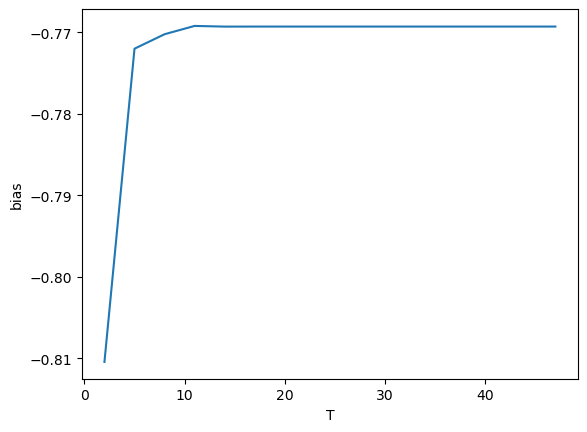

In [20]:
plt.plot(myT, values - myT*values_inf)
plt.xlabel('T')
plt.ylabel('bias')

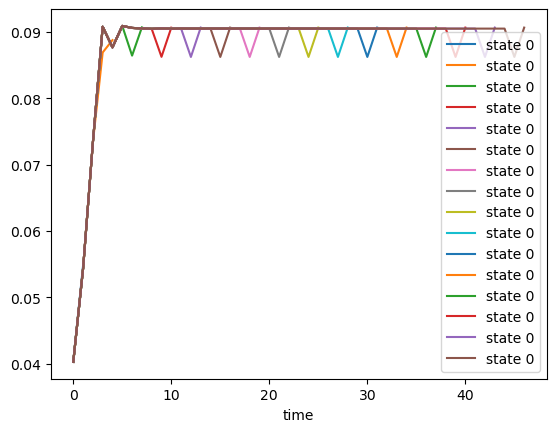

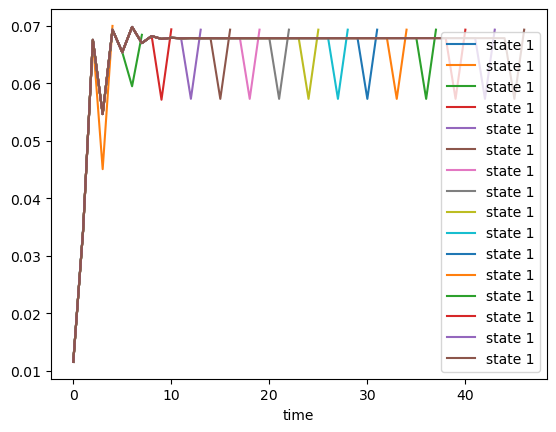

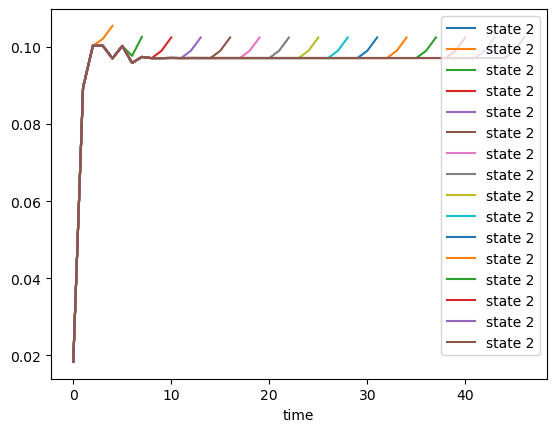

In [21]:
for i in [0, 1, 2]:
    plt.figure()
    for y in ys:
        plt.plot(np.sum(y[:, :, i], 1), label="state {}".format(i))
    plt.xlabel('time')
    plt.legend()


In [7]:
#init = np.sum(y_inf,0)
#for T in [100, 500, 1000]:
#    print('T=',T)
#    %time prob, variables = construct_LP(P0,P1,P2,R0,R1,R2,init,D,b,T)
#    %time prob.solve(pulp.PULP_CBC_CMD(msg=0))


## Plugging two policies as a function of time. 

450.9792763324705 < 450.99628591853536


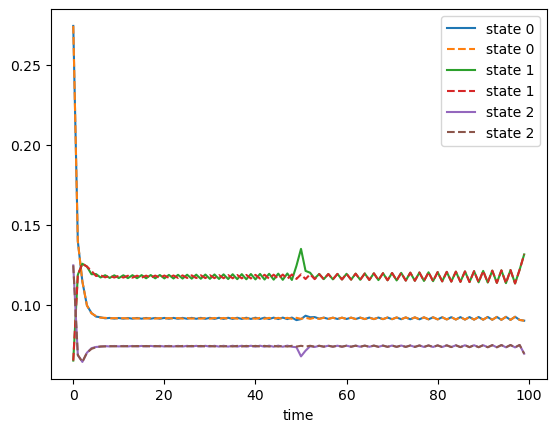

In [8]:
T=50
#init = np.sum(y_inf,0)
value50, y50 = get_value_and_y(P0,P1,P2,R0,R1,R2,init,D,b,T)
init2 = y[-1].reshape(30) @ np.array([P0,P1,P2]).reshape(30,10) # should be the 'next' time step
value50_2, y50_2 = get_value_and_y(P0,P1,P2,R0,R1,R2,init2,D,b,T)
value100, y100 = get_value_and_y(P0,P1,P2,R0,R1,R2,init,D,b,100)

ms = list([m for m in np.sum(y50, 1)])
for m in np.sum(y50_2, 1): ms.append(m)
ms = np.array(ms)
for i in [0, 1, 2]:
    plt.plot(ms[:,i], label="state {}".format(i))
    #plt.plot(np.arange(50,100),np.sum(y50_2[:, :, i], 1), label="state {}".format(i))
    plt.plot(np.sum(y100[:, :, i], 1), '--', label="state {}".format(i))
plt.xlabel('time')
plt.legend()

print(value50+ value50_2, '<', value100) 


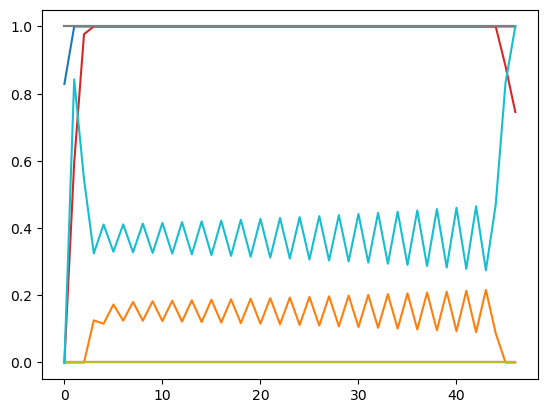

In [9]:
pi = y[:,0,:] / np.sum(y,1)
plt.plot(pi)

## policy around fixed point

Is that linear?

In [10]:
m_star = np.sum(y_inf,0)
error = np.random.rand(S)
error -= np.mean(error)

In [11]:
valuesm = []
valuesy = []
for delta in np.linspace(-1,1,30)*0.01:
    m_new = m_star + error*delta
    _, y1 = get_value_and_y(P0,P1,P2,R0,R1,R2,m_new,D,b,50)
    y_new = y1[0]
    valuesm.append(m_new)
    valuesy.append(y_new-y_inf)
valuesm = np.array(valuesm)
valuesy = np.array(valuesy)

/var/folders/1_/p5wrxxh10ds1d_5qxhrgkfd00000gn/T/ipykernel_55717/702532967.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(valuesy[:,0,i] / valuesy[-1,0,i])
/var/folders/1_/p5wrxxh10ds1d_5qxhrgkfd00000gn/T/ipykernel_55717/702532967.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(valuesy[:,0,i] / valuesy[-1,0,i]-np.linspace(-1,1,30))


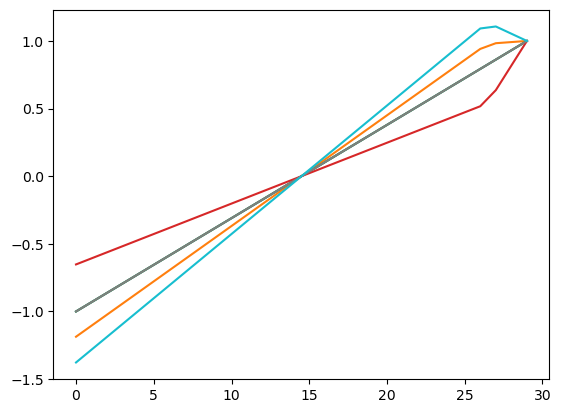

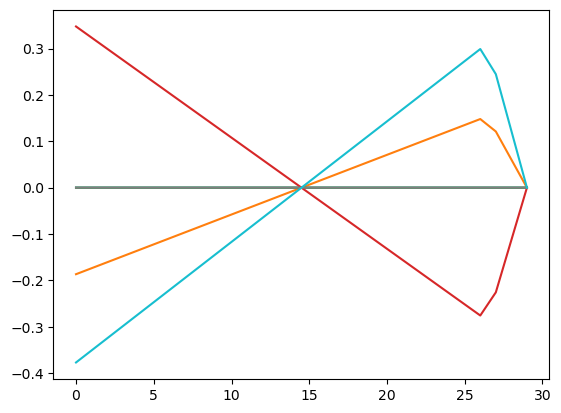

In [12]:
for i in range(10):
    plt.figure(0)
    plt.plot(valuesy[:,0,i] / valuesy[-1,0,i])
    plt.figure(1)
    plt.plot(valuesy[:,0,i] / valuesy[-1,0,i]-np.linspace(-1,1,30))


# Code to find other examples

In [13]:
for i in range(100):
    P0,P1,P2,R0,R1,R2,init,D,b = random_paras(S)
    value50, y = get_value_and_y(P0,P1,P2,R0,R1,R2,init,D,b,50)
    value49, y = get_value_and_y(P0,P1,P2,R0,R1,R2,init,D,b,49)
    values_inf, y_inf = get_value_and_y(P0,P1,P2,R0,R1,R2,init,D,b,np.inf)
    if np.abs(value50-value49 - values_inf) > 1e-5:
        #np.savez('new-params2', P0,P1,P2,R0,R1,R2,init,D,b)
        print(i)
        STOP
    else:
        print('\r',i,end=' ')

 11 

KeyError: Y_2_3

In [ ]:
#np.savez('new-params2', P0,P1,P2,R0,R1,R2,init,D,b)

array([0.       , 0.       , 0.       , 0.5548936, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ])